In [1]:
# LINEAR VARIABLE TAPER CUT
# This program computes and outputs (to the text file ToolpathList.txt) a set of tool position vectors for a variable taper toolpath on Mantis

# The config file is a list of tunable parameters that influences the toolpath 

# 4+1 CNC process, XYZA stages run in pseudo-simultanous motion, C is used for positioning

# The output is a 1x6 vector ToolPosition = [x,y,x,a,c,mark/jump] where ToolPosition[5] toggles the laser state

In [2]:
# CONFIG FILE
# The config file contains parameter used to calculate the toolpath and run metrics
# Units: mm, mm/sec, degrees
import numpy as np
from mpl_toolkits import mplot3d
import matplotlib.pyplot as plt

# Laser raster parameters
jump_speed        = 2000   
mark_speed        = 200    
xy_spacing        = 0.005  
z_spacing         = 0.05
beam_angle        = 3
precision         = 4
#focusDiameter     = .02
#rayleighLength    = .6
#PulseRate         = 5000

# Desired cut line
initial_xy        = [-5,0]
final_xy          = [5,0]
z_depth           = 4
kerf_angle        = 4
# kerf angle must be >= beam_angle
xy_overshoot      = .25
z_overshoot       = .5
top_width_limit   = round(z_depth*np.sin(np.radians(beam_angle)),precision)
#print('top_width_limit =',top_width_limit)
top_width_kerf    = round(z_depth*np.sin(np.radians(kerf_angle)),precision)
#print('top_width_kerf =',top_width_kerf)
bottom_width      = top_width_kerf
# bottom_width defines the bottom width of a linear cut
kerf_shape        = 0
# kerf_shape is a parameter that shears the 3D cut shape
# = 0 the cut is symmetric on both side walls 
# < 0 means that the 3D cut shape shears to + y by a linear factor proportional to top_width_kerf
# > 0 means that the 3D cut shape shears to - y by a linear factor proportional to top_width_kerf

# Block measurements, assume rectangular prism geometry
z_dimension       = 4
x_dimension       = 10
y_dimension       = 10

# Block placement offsets
# the parameters below are not configured yet 
#origin_x          = 0
#origin_y          = 0
#physical_rotation = 0

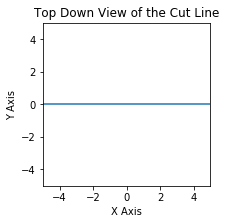

equation of plane is 
-0.0 x + 40 y + 0.0 z + 5.58 = 0.
equation of plane is 
-0.0 x + 40 y + 0.0 z + -5.58 = 0.


(0, 4)

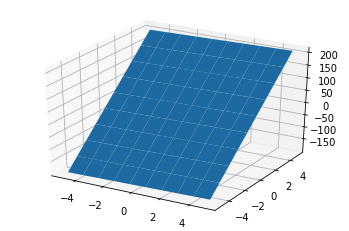

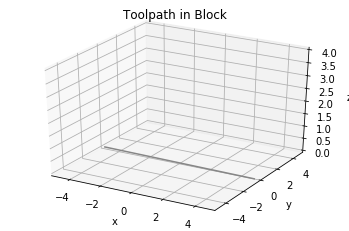

In [3]:
# TOOLPATH VISUALS
import numpy as np
from mpl_toolkits import mplot3d
import matplotlib.pyplot as plt

# 2D Model
# top down view of cutline
xRange = np.linspace(initial_xy[0], final_xy[0])
yRange = np.linspace(initial_xy[1], final_xy[1])
plt.figure(figsize = [3,3])
plt.plot(xRange, yRange)
plt.xlim(-x_dimension/2, x_dimension/2)
plt.ylim(-y_dimension/2, y_dimension/2)
plt.title('Top Down View of the Cut Line')
plt.xlabel("X Axis")
plt.ylabel("Y Axis")
plt.show()


# 3D Model
def plane_eq(p,q,r):  
    a1 = q[0] - p[0]
    b1 = q[1] - p[1]
    c1 = q[2] - p[2]
    a2 = r[0] - p[0]
    b2 = r[1] - p[1]
    c2 = r[2] - p[2]
    a = b1*c2 - b2*c1 
    b = a2*c1 - a1*c2 
    c = a1*b2 - b1*a2 
    d = (- a*p[0] - b*p[1] - c*p[2]) 
    print("equation of plane is "), 
    print(a, "x +", b, "y +", c, "z +", d, "= 0.")
    return [a,b,c,d]

# Define cut sidewall 1
p1 = (initial_xy[0], initial_xy[1] - top_width_kerf/2, z_depth)
q1 = (final_xy[0], final_xy[1] - top_width_kerf/2, z_depth)
r1 = (initial_xy[0], initial_xy[1] - bottom_width/2 + kerf_shape ,0)
sidewall_1 = plane_eq(p1,q1,r1)

# Define cut sidewall 2
p2 = (initial_xy[0], initial_xy[1] + top_width_kerf/2, z_depth)
q2 = (final_xy[0], final_xy[1] + top_width_kerf/2, z_depth)
r2 = (initial_xy[0], initial_xy[1] + bottom_width/2 + kerf_shape ,0)
sidewall_2 = plane_eq(p2,q2,r2)

# Interactive graph of block with total theoretical ablated volume highlighted
x = np.linspace(-5,5,10)
y = np.linspace(-5,5,10)

X,Y = np.meshgrid(x,y)
Z = X + 40*Y + 5.58

fig = plt.figure()
ax = fig.gca(projection='3d')

surf = ax.plot_surface(X, Y, Z)
fig = plt.figure()
ax = plt.axes(projection='3d')
ax.contour3D(X, Y, Z, 50, cmap='binary')
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')

plt.title("Toolpath in Block")
# block dimensions
plt.xlim(-x_dimension/2, x_dimension/2)
plt.ylim(-y_dimension/2, y_dimension/2)
ax.set_zlim(0,z_dimension)

In [4]:
# TOOL POSITION VECTOR GENERATOR
# Initialize tool position vector as a list (X, Y, Z, A, C, mark/jump)
# ToolPositon[5]: 0 = jump, 1 = mark
ToolPosition = [0,0,0,0,0,0]

# Open and overwrite a .txt file with the initial vector
w = open("ToolpathList.txt", "w")
w.write(str(ToolPosition))
w.close()

# Define function to write updated position vectors to the .txt file
def write(w, ToolPosition):
    w = open("ToolpathList.txt", "a")
    w.write(str(ToolPosition))
    w.close()
    
# Rotate the block in C so that the cut line runs parallel to the X axis
c = np.arctan((final_xy[1]-initial_xy[1])/(final_xy[0]-initial_xy[0]))
c = round(np.degrees(c),precision)
ToolPosition[4]    = -c
write(w,ToolPosition)

# transform XY coordinates to match C rotation
initial_xy_rotated = initial_xy
final_xy_rotated   = final_xy


# Rotate A axis so that a XY raster at a given kerf angle would make the 
# outer wall of the cut parallel to the Z axis




# Start XY position, set laser to mark
x = initial_xy_rotated[0]
y = initial_xy_rotated[1]
ToolPosition[0]    = x
ToolPosition[1]    = y
ToolPosition[5]    = 1
write(w, ToolPosition)

# Raster along XY path
x = final_xy_rotated[0]


    


# Calculate range of Y values over which the rocking will occur
# yRange = 

# Fix C axis
# Scan over Z range
    # Scan over X range
        #Scan over A range
            # Scan over Y range




# rotate the block to desired cut angle  C_i and A_i
# account for kerf constant offset


# add Z+i correction


# scan along X to complete one line of the raster


# rotate to next A_i+1
# steps interpolated over cut width in Y using np.linspace
# spacing defined by spot size, rayleigh range of laser, rep rate, other laser physics


# translate to new Y_i+1


# calculate and update new Z_i+1 height


# scan along X to complete second raster line in the opposite direction of the first


# loop over range necessary to complete one z layer of raster


# go down to second layer and repeat


# loop over layers


# append 'jump' or 'mark' to each vector




In [5]:
# METRICS
# Program runtime estimate


# Toolpath runtime estimate


# Laser uptime estimate


# Material loss estimate


# Stage Kinematics

In [6]:
# bit flipping function
import numpy as np
def bitFlip(bit):
    bit = np.absolute(bit-1)
    return bit
bit = 1
bitFlip(bit)

#print(np.degrees( ))
#print(np.radians( ))
print(15*np.sin(np.radians(3)))

0.7850393436441575
